In [1]:
# import modules
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import display
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import scipy

2022-04-20 09:56:32.913462: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-20 09:56:32.913595: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train = pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv")
test = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")
labels = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")

In [3]:
train.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [4]:
# first 60 seconds
# train[train['sequence']==0]

In [5]:
len(train[train['subject']==47])

6240

In [6]:
test.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.0,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.0,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.0,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.0,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.0,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483


In [7]:
labels.head()

,sequence,state
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [8]:
def sub_imp(x):
    if x < 25:
        return 0
    elif x > 95:
        return 2
    else:
        return 1
    
def engineering(df):
    for sensor in sensors:
        # add lag feature and difference
        df[sensor + '_lag1'] = df.groupby('sequence')[sensor].shift(1)
        # df[sensor + '_lag10'] = df.groupby('sequence')[sensor].shift(10)
        # df[sensor + '_back_lag1'] = df.groupby('sequence')[sensor].shift(-1)
        df.fillna(0, inplace=True)
        df[sensor + '_diff1'] = df[sensor] - df[sensor + '_lag1']   
        
    sub_stat = df[['sequence', 'subject']].drop_duplicates().groupby('subject').agg({'sequence': 'count'})\
    .rename(columns={'sequence': 'count'}).reset_index()
    df = df.merge(sub_stat, on='subject', how='left')
    df['sub_imp'] = df['count'].apply(lambda x: sub_imp(x))
    df.drop('count', axis=1, inplace=True)
    
    return df

In [9]:
sensors = [col for col in train.columns if 'sensor_' in col]
train = engineering(train)
test = engineering(test)

In [10]:
train = pd.merge(train, labels, how='left', on="sequence")
labels = train['state'].to_numpy().reshape(-1, 60)

In [11]:
groups = train['sequence']
train = train.drop(['sequence', 'subject', 'step', 'state'], inplace=False, axis=1).values
test = test.drop(['sequence', 'subject', 'step'], inplace=False, axis=1).values

In [12]:
labels.shape

(25968, 60)

In [13]:
scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [14]:
print(train.shape)
print(test.shape)

# reshape dataset as an input of LSTM model
train = train.reshape(int(len(train)/60), 60, train.shape[-1])
test = test.reshape(int(len(test)/60), 60, test.shape[-1])

print(f'train reshape: {train.shape}')
print(f'test reshape: {test.shape}')

(1558080, 40)
(733080, 40)
train reshape: (25968, 60, 40)
test reshape: (12218, 60, 40)


In [15]:
from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.metrics import AUC

def BuildNN():
    with tpu_strategy.scope():
        ip = Input(shape=(60, train.shape[-1]))
        x1 = Bidirectional(LSTM(768, return_sequences=True))(ip)
        
        x21 = Bidirectional(LSTM(512, return_sequences=True))(x1)
        x22 = Bidirectional(LSTM(512, return_sequences=True))(ip)
        l2 = Concatenate(axis=2)([x21, x22])
        
        x31 = Bidirectional(LSTM(384, return_sequences=True))(l2)
        x32 = Bidirectional(LSTM(384, return_sequences=True))(x21)
        l3 = Concatenate(axis=2)([x31, x32])
        
        x41 = Bidirectional(LSTM(256, return_sequences=True))(l3)
        x42 = Bidirectional(LSTM(128, return_sequences=True))(x32)
        l4 = Concatenate(axis=2)([x41, x42])
        
        l5 = Concatenate(axis=2)([x1, l2, l3, l4])
    
        x7 = Dense(128, activation='selu')(l5)
        x8 = Dropout(0.3)(x7)
        op = Dense(units=1, activation="sigmoid")(x8)
    
        model = Model(inputs=ip, outputs=op, name='DNN_Model')

        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[keras.metrics.AUC()])
    return model

In [16]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

2022-04-20 09:57:11.595131: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-20 09:57:11.598547: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-04-20 09:57:11.598598: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-20 09:57:11.598628: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (09c096aa617a): /proc/driver/nvidia/version does not exist
2022-04-20 09:57:11.601899: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [17]:
cv_score = 0
test_preds = []
kf = GroupKFold(n_splits=5)

for fold_idx, (train_idx, valid_idx) in enumerate(kf.split(train, labels, groups.unique())):
    # split train and label into X, y train and valid set.
    X_train, X_valid = train[train_idx], train[valid_idx]
    y_train, y_valid = labels[train_idx], labels[valid_idx]
    
    # Run the model
    model = BuildNN()
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=64, 
              callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)])
    
    # add roc_auc_score of each fold
    score = roc_auc_score(y_valid, model.predict(X_valid).squeeze())
    print(score)
    cv_score += score
    
    # append predictions
    test_preds.append(model.predict(test).squeeze())
    
print(cv_score/5)

Epoch 1/100
325/325 [==============================] - 103s 191ms/step - loss: 0.6549 - auc: 0.6736 - val_loss: 0.4886 - val_auc: 0.8448
Epoch 2/100
325/325 [==============================] - 35s 109ms/step - loss: 0.4927 - auc: 0.8400 - val_loss: 0.3917 - val_auc: 0.9071
Epoch 3/100
325/325 [==============================] - 36s 109ms/step - loss: 0.3722 - auc: 0.9141 - val_loss: 0.3229 - val_auc: 0.9368
Epoch 4/100
325/325 [==============================] - 35s 109ms/step - loss: 0.2816 - auc: 0.9515 - val_loss: 0.2858 - val_auc: 0.9517
Epoch 5/100
325/325 [==============================] - 35s 109ms/step - loss: 0.2316 - auc: 0.9672 - val_loss: 0.2717 - val_auc: 0.9559
Epoch 6/100
325/325 [==============================] - 35s 109ms/step - loss: 0.2001 - auc: 0.9752 - val_loss: 0.2711 - val_auc: 0.9595
Epoch 7/100
325/325 [==============================] - 36s 109ms/step - loss: 0.1659 - auc: 0.9826 - val_loss: 0.3201 - val_auc: 0.9581
Epoch 8/100
325/325 [==========================

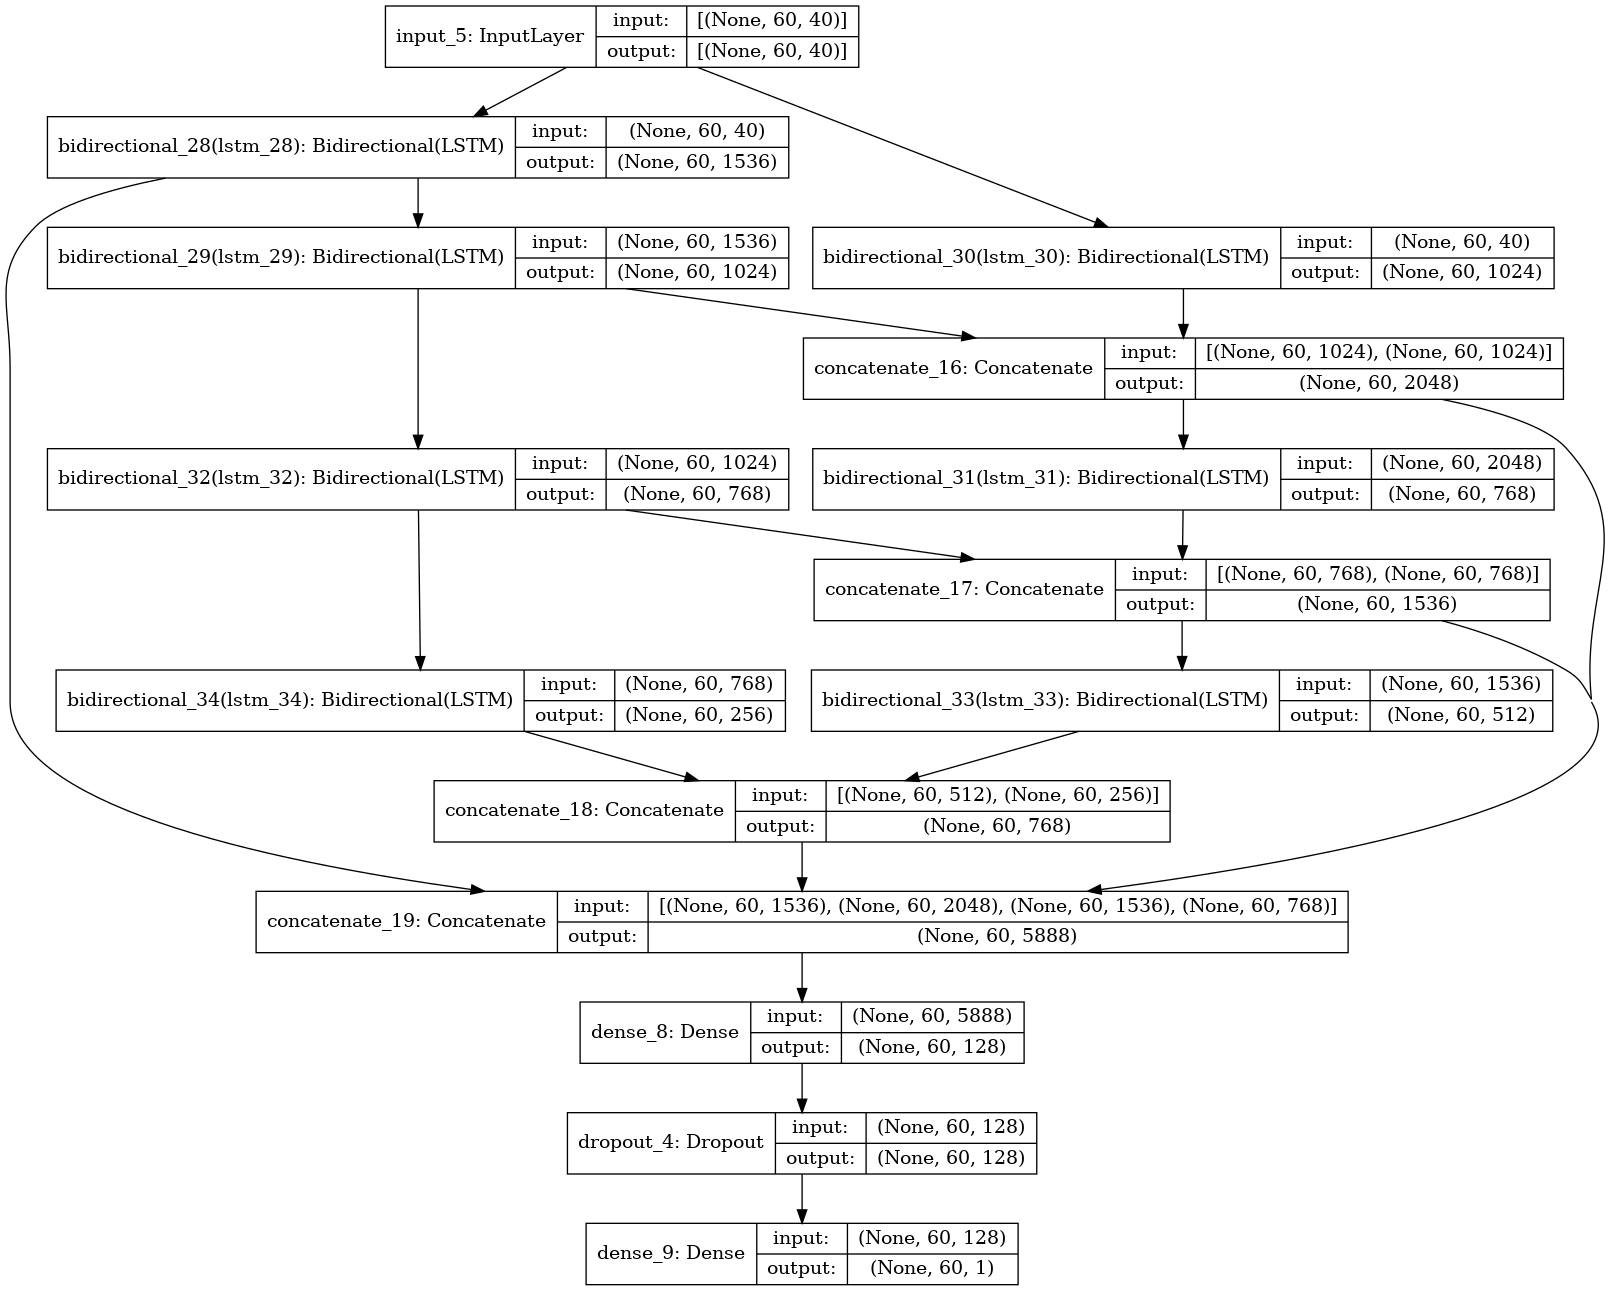

In [18]:
keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [19]:
submission["state"] = sum(test_preds)/5
submission.to_csv("submission.csv", index=False)
submission.head()

,sequence,state
0,25968,0.979550
1,25969,0.988872
2,25970,0.006747
3,25971,0.743549
4,25972,0.178832
